<a href="https://colab.research.google.com/github/priyanjanjb/Cat-or-Dog-Image-Classifier/blob/Classifier/CatOrDog_TransferLearnig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow -q
!pip install numpy -q
!pip install matplotlib -q
!pip install pandas -q

!pip install opendatasets -q


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time #calculate time

import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification') #download dataset

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: priyanjanperera16
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:01<00:00, 126MB/s]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128) #height and width

In [5]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory (train_data_dir,
                                                         batch_size =BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = "training",
                                                         validation_split = 0.1,
                                                         seed = 42)

validation_data = tf.keras.utils.image_dataset_from_directory (train_data_dir,
                                                         batch_size =BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = "validation",
                                                         validation_split = 0.1,
                                                         seed = 42)
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size =BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         )

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [7]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape) #(32, 128, 128, 3) batch size 32 imge size 128 128 color chanal 3
  print (label_batch.shape)

(32, 128, 128, 3)
(32,)


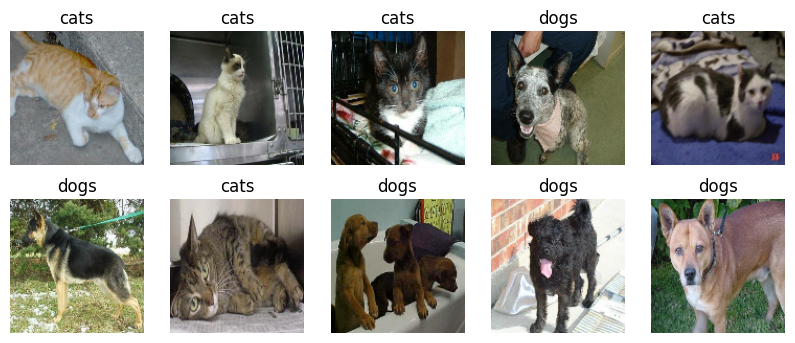

In [10]:
#plot data sample
plt.figure(figsize=(10,4))
for image,label  in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis("off")

Scalling data set to same size to improve train speed

In [11]:
train_data = train_data.map(lambda x,y:(x/255.0,y))
validation_data = validation_data.map(lambda x,y:(x/255.0,y))
test_data = test_data.map(lambda x,y:(x/255.0,y))

## **Transfer learming**

[link text](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [12]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False #bcz dont want to retrain

83683744/83683744 [==============================] - 1s 0us/step


## Model Building

In [13]:
#model architecture
model = tf.keras.models.Sequential() #model object

model.add(pretrained_model) #add pretraind model

model.add(tf.keras.layers.Flatten())
#if we want we can add more layers
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21144425 (80.66 MB)
Trainable params: 2829

In [15]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
                                                    #binary value check therefore use BinaryCrossentrophy use


## Model Training

In [17]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=3,
                    validation_data=validation_data)

end_time = time.time()


Epoch 1/3
225/225 [==============================] - 543s 2s/step - loss: 0.0780 - accuracy: 0.9671 - val_loss: 0.1020 - val_accuracy: 0.9625
Epoch 2/3
225/225 [==============================] - 561s 2s/step - loss: 0.0734 - accuracy: 0.9729 - val_loss: 0.1057 - val_accuracy: 0.9575
Epoch 3/3
225/225 [==============================] - 553s 2s/step - loss: 0.0588 - accuracy: 0.9761 - val_loss: 0.1431 - val_accuracy: 0.9538


In [19]:
print(f'Total time for training {((end_time-start_time)/3600):.3f} sec')

Total time for training 0.463 sec


## Performance Analysis

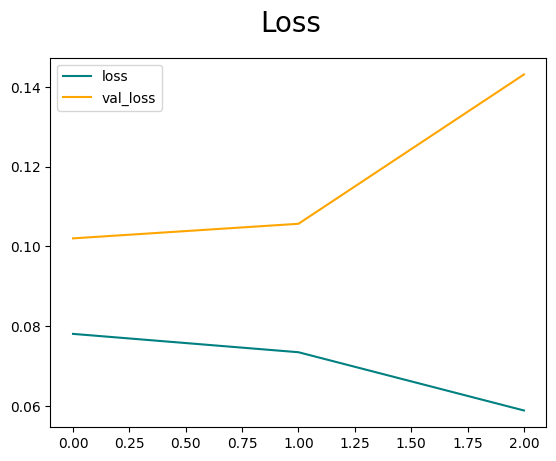

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

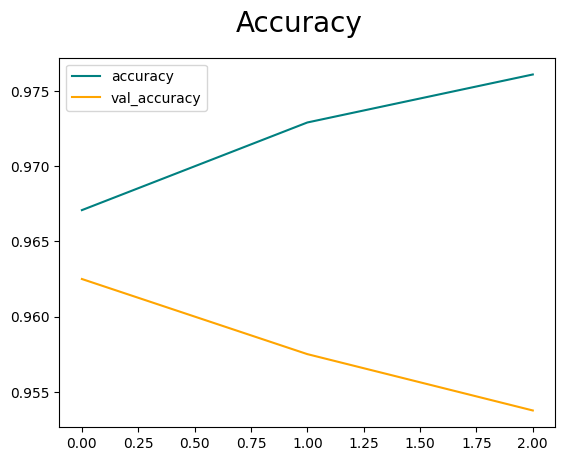

In [21]:

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## **Model Evaluation**

In [22]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()


In [23]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [24]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9310345>

In [25]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.972>

In [26]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.95>

### **Test**

In [27]:
!pip install opencv-python -q

In [28]:
import cv2

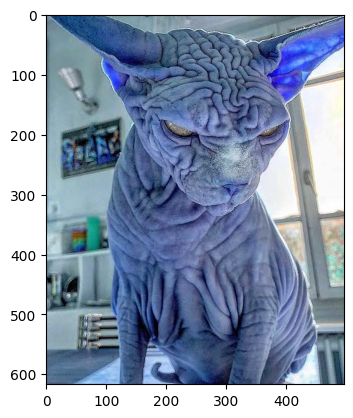

In [29]:
img = cv2.imread('/content/images.jpeg')
plt.imshow(img)
plt.show()

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [32]:
scaled_image.shape

TensorShape([128, 128, 3])

In [33]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [34]:
y_hat  = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 167ms/step


In [35]:
y_hat

array([[0.15796272]], dtype=float32)

In [36]:
class_names

['cats', 'dogs']

In [37]:
if y_hat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')


cats
